In [3]:
# the task is to train the model through tabpfn and predict the amount for any particular productId. I want good prediction accuracy. Currently I'm getting SMAPE of 199%, go through the whole code and fix wherever required for getting good accuracy.

In [4]:
import pandas as pd
import numpy as np

In [5]:
df = pd.read_csv(r"C:/Kenil Ramani/QB/GoalBot/CSV/dataset_v4.05.csv")

In [6]:
df['amount'] = df['amount'].round().astype('Int64')    # does not give error due to Int

In [7]:
df['productId'].unique()                # has 138 different productIds

array([  166,    36,    46,     2,     8,    38,   177,    35,     1,
         170,    48,   180,    17,    50,   230,   216,    27,   195,
         210,   192,   248,    37,    75,   244,    79,   283,   165,
         167,   260,    71,    42,    12,    43,   228,   271,   196,
         285, 17229,   198,   206,    11,    26,   173,    70,   168,
         189,    52,    76,   217,   249,   181, 17233,   188, 17367,
       17558, 17366,   232, 17560, 17616, 17625, 17617,   220,   222,
         190,   193,   205,   325,   229,   169, 17235,   194,   233,
         223,   238,   236,   185,   255,   239,   202,   211,   209,
         201, 17244,   277,   218,   203,   213, 17234, 17249,   231,
         212,   252,   234, 17251,   241,   245, 17615,   221, 17624,
         254,   264, 17232,   226,   266,   267,   276,   251,   280,
         227, 17369, 17370,   294,   250,   253,   256,   263,   235,
         257,   278, 17553,   284,   298, 17230,   246, 17362,   261,
       17368,   270,

In [8]:
correlation = df.corr(numeric_only=True)['amount'].sort_values(ascending=False)
print(correlation)

amount                       1.000000
taxableAmount                1.000000
sgstAmount                   0.959873
cgstAmount                   0.959873
rate                         0.951413
pts                          0.951413
qty                          0.206927
billAmount                   0.150140
regionId                     0.119296
mrp                          0.070506
ptr                          0.070152
stockistId                   0.034851
packingTypeId                0.032927
free                         0.023903
categoryId                   0.017219
salesDetails_Id              0.003654
salesId                      0.003208
productId                   -0.000372
hsn                         -0.000691
cityId                      -0.003633
hqId                        -0.006781
addressId                   -0.010997
cashDiscountPercentage      -0.014361
divisionId                  -0.056654
chemistTypeId               -0.083969
chemistId                   -0.092388
sgst        

In [9]:
df_filtered = df[df['productId'] == 165].copy()

In [10]:
# Convert to 10 bins
df_filtered['amount_class'] = pd.qcut(df_filtered['amount'], q=10, labels=False, duplicates='drop')         # i converted to 10 bins because i was getting error if not doing this

In [11]:
features = ['taxableAmount', 'sgstAmount', 'cgstAmount', 'rate', 'pts', 'qty', 'billAmount']    # I found the relation of amount with other columns. I'm taking those columns only which has good correlation, dont change this!
X = df_filtered[features]
y = df_filtered['amount_class']

In [12]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)        # check whether training is done properly or not, why I'm getting 199% SMAPE

In [14]:
from tabpfn import TabPFNClassifier

model = TabPFNClassifier(device="cuda")

model.fit(X_train, y_train)

TabPFNClassifier(device='cuda')

In [15]:
y_pred = model.predict(X_test)

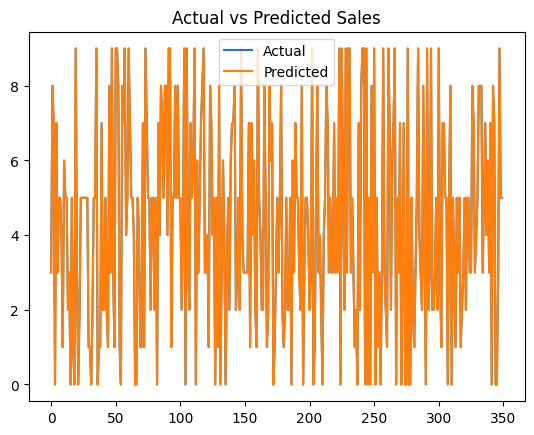

In [16]:
import matplotlib.pyplot as plt

plt.plot(y_test.values, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.title('Actual vs Predicted Sales')
plt.show()

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error

amount_series = df_filtered['amount']
quantile_bins = pd.qcut(amount_series, q=10, duplicates='drop', retbins=True)[1]
bin_centers = 0.5 * (quantile_bins[:-1] + quantile_bins[1:])

y_pred_class = model.predict(X_test)

y_pred = bin_centers[y_pred_class]
y_true = y_test.to_numpy()  # Ensure it's a NumPy array

def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def smape(y_true, y_pred):
    denom = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    return np.mean(np.abs(y_true - y_pred) / denom) * 100

print(f"MAPE: {mape(y_true, y_pred):.2f}%")             # i'm getting inf%, please fix the issue
print(f"SMAPE: {smape(y_true, y_pred):.2f}%")           # i'm getting 199.42%, please fix the issue


MAPE: inf%
SMAPE: 199.42%


C:\Users\User1\AppData\Local\Temp\ipykernel_18252\3618198779.py:15: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


In [8]:
import argparse
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
try:
    from tabpfn import TabPFNClassifier
except ImportError: 
    TabPFNClassifier = None

def mape(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    mask = y_true != 0
    if not np.any(mask):
        return float('inf')  # or return 0, depending on how you want to handle it
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

# def mape(y_true: np.ndarray, y_pred: np.ndarray) -> float:
#     """Mean absolute percentage error."""
#     return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def smape(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    """Symmetric mean absolute percentage error."""
    denom = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    return np.mean(np.abs(y_true - y_pred) / denom) * 100

def load_data(path: str) -> pd.DataFrame:
    df = pd.read_csv(r'C:/Kenil Ramani/QB/GoalBot/CSV/dataset_v4.05.csv')
    df["amount"] = df["amount"].round().astype("Int64")
    df["rate"] = df["rate"].round().astype("Int64")
    df['invoiceDate'] = pd.to_datetime(df['invoiceDate'], errors='coerce')
    return df

def prepare_dataset(df: pd.DataFrame, product_id: int):
    df_filtered = df[df["productId"] == product_id].copy()
    # df_filtered['invoiceDate'] = (df_filtered['invoiceDate'] - pd.Timestamp("1970-01-01")).dt.days

    # bin continuous target for classification
    y_cont = df_filtered["amount"]
    y_class, bins = pd.qcut(y_cont, q=10, labels=False, duplicates="drop", retbins=True)
    bin_centers = 0.5 * (bins[:-1] + bins[1:])

    features = [ 'invoiceDate'
        # "taxableAmount",
        # "sgstAmount",
        # "cgstAmount",
        # "rate",
        # "pts",
        # "qty",
        # "billAmount",
    ]
    X = df_filtered[features]

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    X_train, X_test, y_train_class, y_test_class, y_train_cont, y_test_cont = train_test_split(
        X_scaled, y_class, y_cont, test_size=0.2, random_state=42
    )
    # print(X_test)
    # print(y_test_cont)
    return X_train, X_test, y_train_class, y_test_cont, bin_centers
    


def train_model(X_train, y_train, device: str = "cuda"):
    if TabPFNClassifier is None:
        raise ImportError("tabpfn is required for training")
    model = TabPFNClassifier(device=device)
    model.fit(X_train, y_train)
    return model


def main():
    parser = argparse.ArgumentParser(description="Train TabPFN model to predict amount")
    parser.add_argument("--data", required=True, help="Path to the CSV dataset")
    parser.add_argument("--product_id", type=int, required=True, help="Product ID to filter on")
    parser.add_argument("--device", default="cuda", help="Device for TabPFN (cpu or cuda)")
    import sys
    sys.argv = ['script_name', '--data', 'C:/Kenil Ramani/QB/GoalBot/CSV/dataset_v4.05.csv', '--product_id', '43']

    args = parser.parse_args()

    df = load_data(args.data)
    X_train, X_test, y_train_class, y_test_cont, bin_centers = prepare_dataset(df, args.product_id)
    model = train_model(X_train, y_train_class, device=args.device)
    pred_class = model.predict(X_test)
    y_pred = bin_centers[pred_class]

    print(f"MAPE: {mape(y_test_cont.to_numpy(), y_pred):.2f}%")
    print(f"SMAPE: {smape(y_test_cont.to_numpy(), y_pred):.2f}%")


if __name__ == "__main__":
    main()

MAPE: 55.12%
SMAPE: 64.83%
